In [1]:
import sys
sys.path.append('./')
import DataGen
import technical_indicators as ti
import seaborn as sns
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from strategy_test import strategy_test
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from itertools import compress
import json
import joblib
import utils
import ml_model as ml
import warnings

This notebook provide an interface of leveraging machine learning to tune the technique indicator of certain funcation to predict when to buy in crypto currencies. https://mrjbq7.github.io/ta-lib/ provides a wide range of technique indicators to perform price movement analysis. Yet for each of the technique indicator, there are certain parameters to tune. Some strategies require more than one values of the indicators. Thus how to choose the parameters and group values of similar functioning indicators is where the machine learning techniques come to paly. This projects leverage **ta-lib** as the back end to calculates technique indicators. I created a class *technical_indicators* to provide a user-friendly interface for the user to call and calculates different technical indicators.

In [2]:
dg=DataGen.DataGen('Gemini','BTC','D')
dg.load()

windowsizes=[int(x) for x in np.linspace(1,90,90)]
responses=dg.get_leading_log_rt(windowsizes)
responses.dropna(inplace=True)

data=dg.get_data()


First, similar to the notes in *"composite_indicators_strategy.ipynb"*, user can load data from the desired source and specifiying the attributes of the data such as name for the crypto currency and the data frequency.
'D' for daily data. 'H' for hourly data.<br>
<br>
Next user can specify the investment horizen of choice by specifying the value of *target_window* in the cell below. Also the user can specify the name of the single indicator they choose to train.

In [3]:
target_window=15
TID_name='RSI'
tid=ti.technical_indicators(data)

One has to specify the list of parameters they wants to explore. They are two ways of doing this. One is to get the help from the interface of the technical_indicators to get the information of the input parameters of the specified name of the indicator, such as *'RSI'*.

In [7]:
tid.get_info('RSI')

{'name': 'RSI', 'group': 'Momentum Indicators', 'display_name': 'Relative Strength Index', 'function_flags': ['Function has an unstable period'], 'input_names': OrderedDict([('price', 'close')]), 'parameters': OrderedDict([('timeperiod', 14)]), 'output_flags': OrderedDict([('real', ['Line'])]), 'output_names': ['real']}


In [8]:
tid.get_info('BBANDS')

{'name': 'BBANDS', 'group': 'Overlap Studies', 'display_name': 'Bollinger Bands', 'function_flags': ['Output scale same as input'], 'input_names': OrderedDict([('price', 'close')]), 'parameters': OrderedDict([('timeperiod', 5), ('nbdevup', 2), ('nbdevdn', 2), ('matype', 0)]), 'output_flags': OrderedDict([('upperband', ['Values represent an upper limit']), ('middleband', ['Line']), ('lowerband', ['Values represent a lower limit'])]), 'output_names': ['upperband', 'middleband', 'lowerband']}


In [4]:
paralist=[[x] for x in windowsizes[1:]]
tech=tid.get_idts(TID_name,paralist)

One can specify the list of parameters they want to try by creating a 2-D list as above. Alternatively, I have created a configuration function which generates the parameters list automatically for the targeted investment horizon as following:

In [11]:
paralist=ml.ml_config(target_window)[TID_name]
print(paralist)

[[15], [30], [45], [60], [75], [90]]


In [5]:
tech.dropna(inplace=True)
start=max(tech.index.min(),responses.index.min())
end=min(tech.index.max(),responses.index.max())
target='log_rt_'+str(target_window)
X=tech.loc[start:end,:]
Y=responses.loc[start:end,[target]]

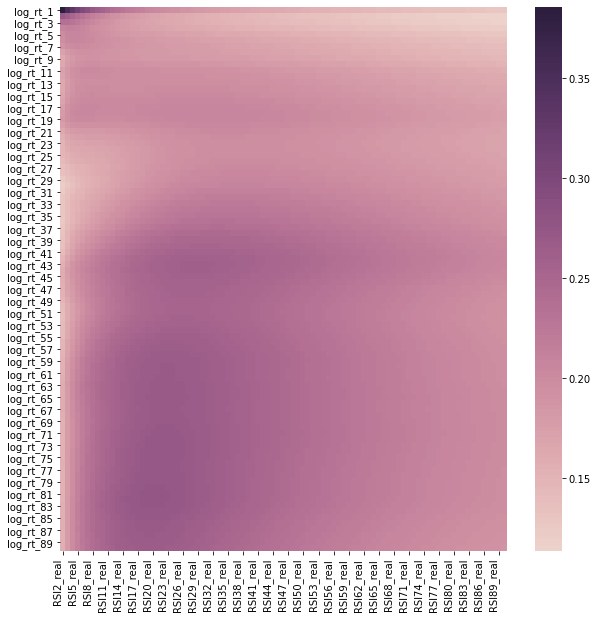

In [15]:
corr=utils.corr_plot(responses,tech,TID_name)

Correlation plot gives the user a quick view of the relationship betwen technique indicators and targetd variables, which are the leading log return of different investment horizons.<br>
<br>
However, I decided to use *sklearn.feature_selection* to select indicators.

As shown below, I wrote a function *ml.feature_selection* to help user specify the number of features that they like to use for modelling. The negtive log p values of each feature is plotted base on univariate analysis. It returns top m features for m as the number of features user specified. The user can adjust the numbers of features based on the plot below.

Index(['RSI25_real', 'RSI26_real', 'RSI27_real', 'RSI28_real', 'RSI29_real',
       'RSI30_real', 'RSI31_real'],
      dtype='object')

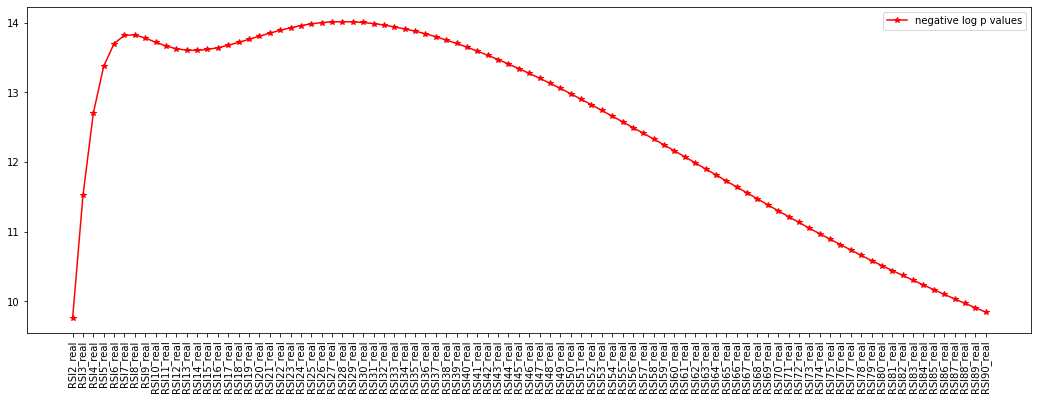

In [45]:
inds=ml.feature_selection(X,Y,7)
tech.columns[inds]

After deciding the number of features to use. One can call the machine learning package to train and test the model.I used 90 days as the shifting window to split the time series data into multiple blocks to train and cross validate it.(Based on the assumptions that the machine learning models will be re-calibrated every 90 days).<br>
As we can see below, machine learning improved the precision and avg. return for technique indicators compared to traditional hard-coded rules.

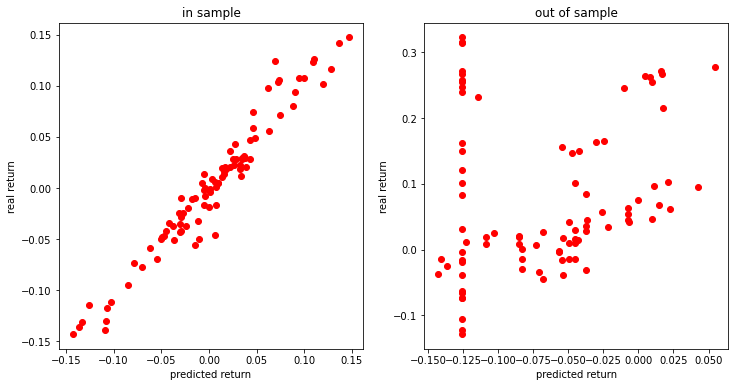

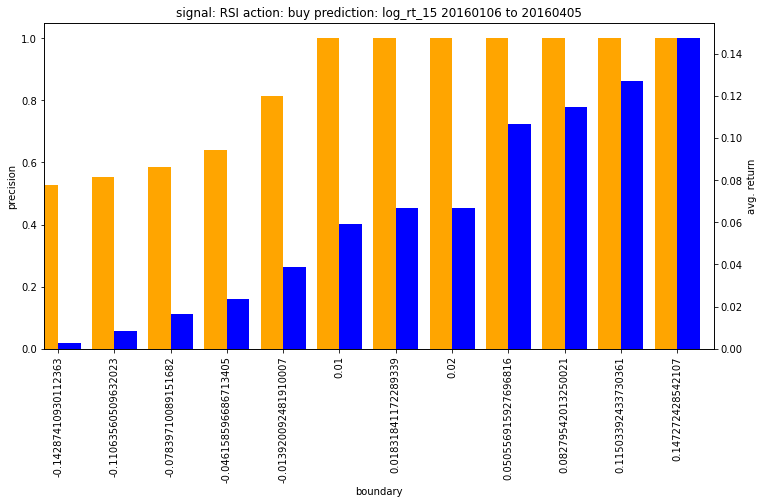

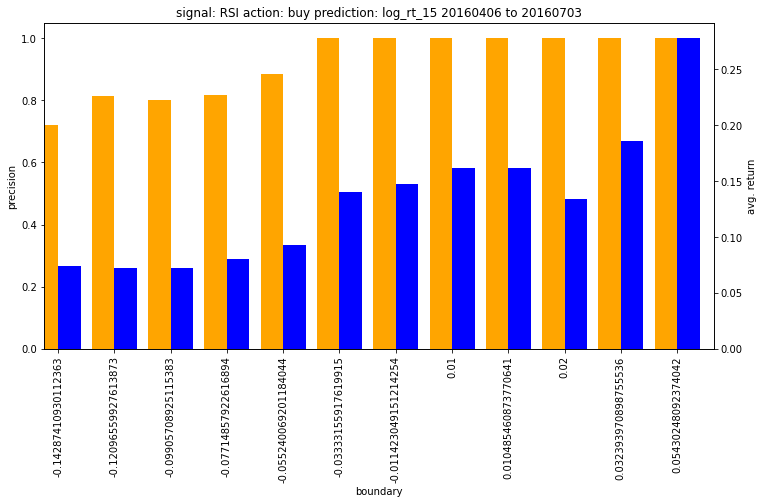

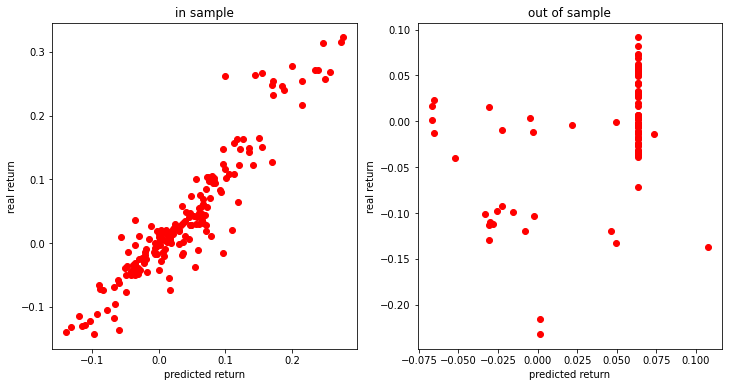

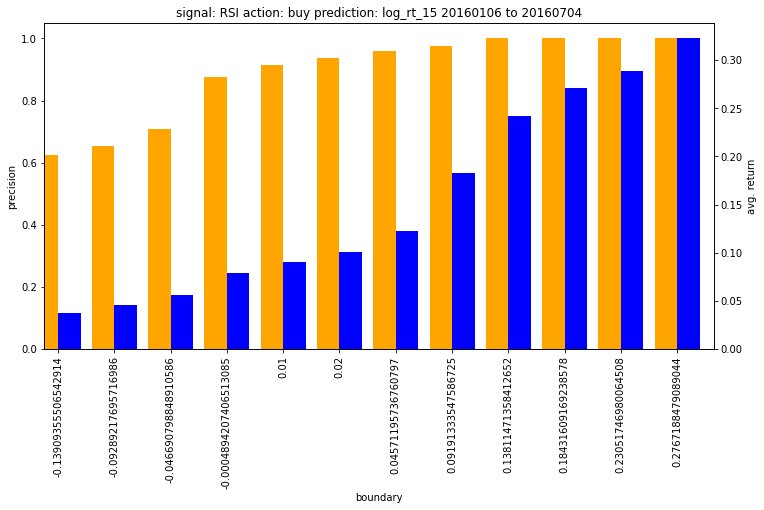

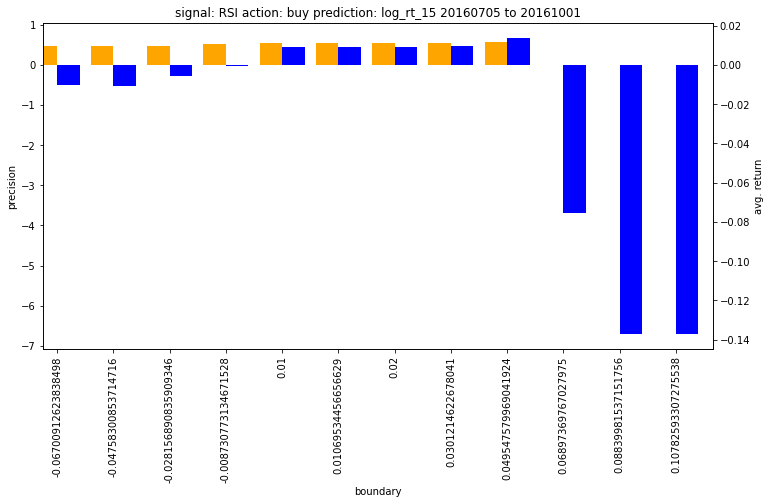

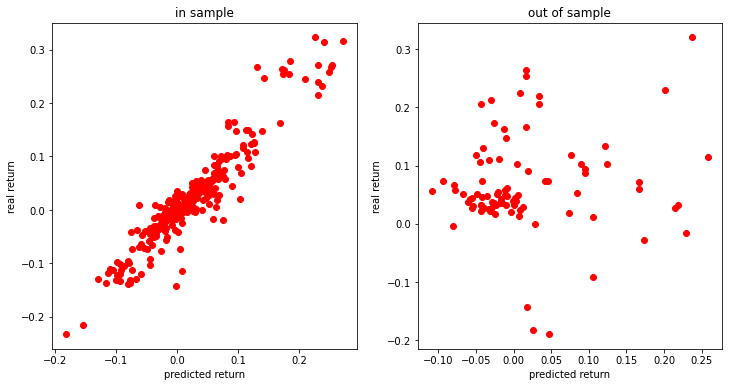

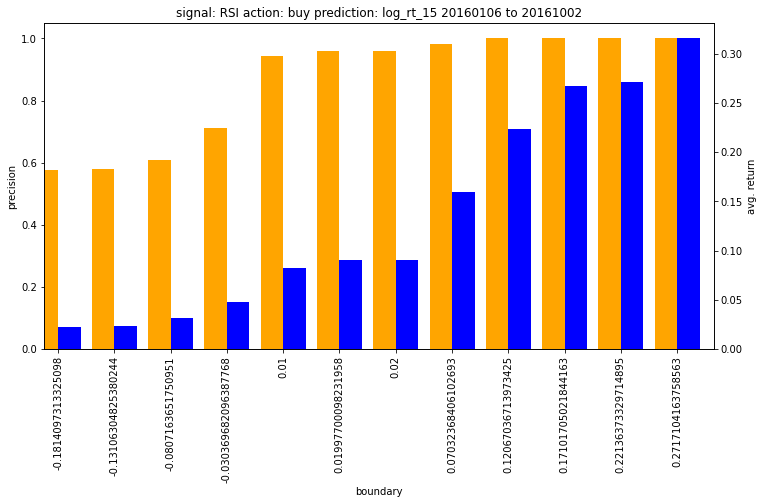

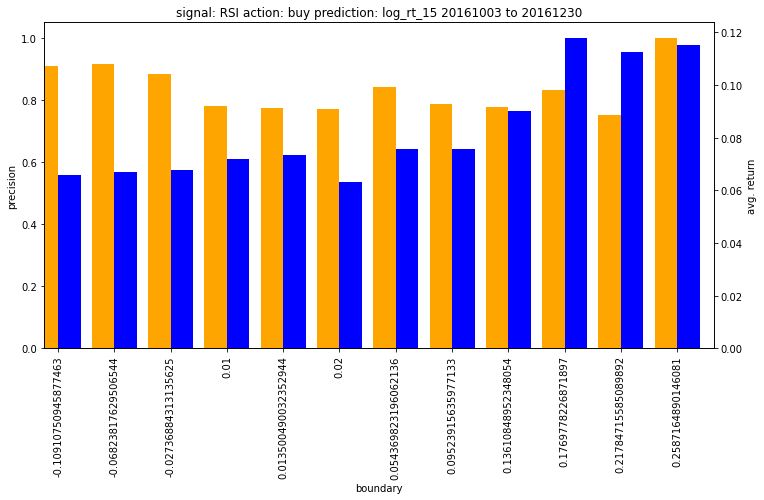

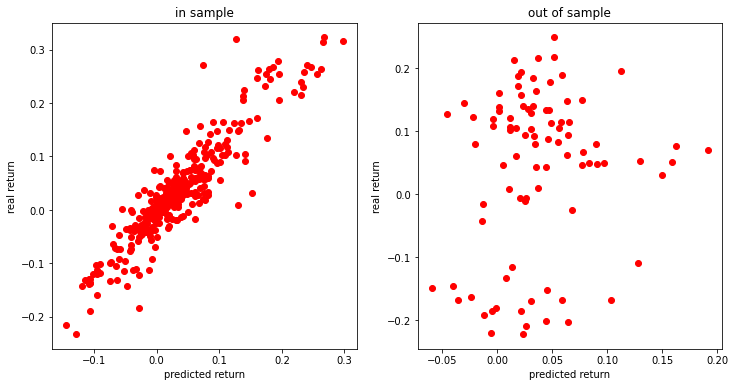

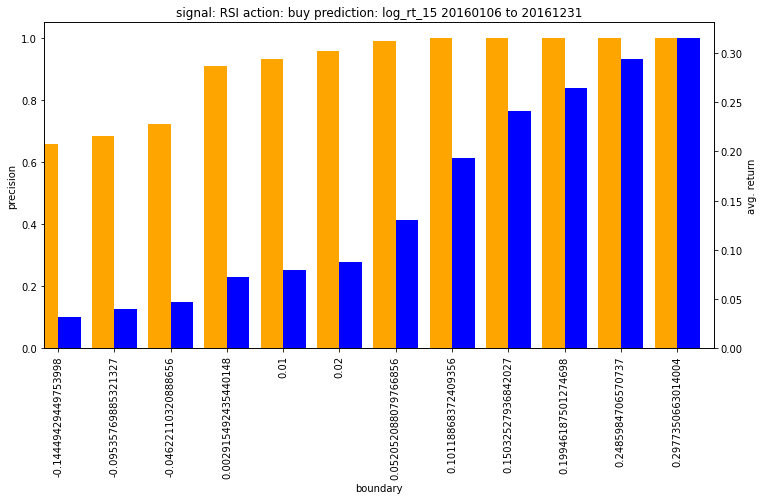

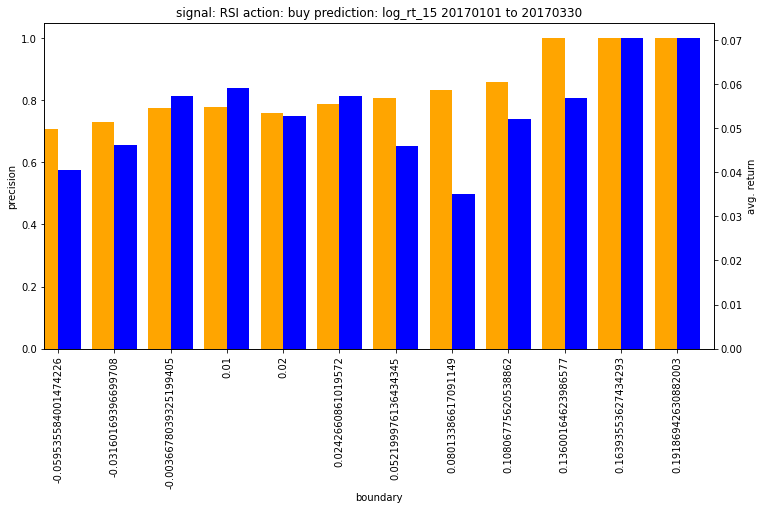

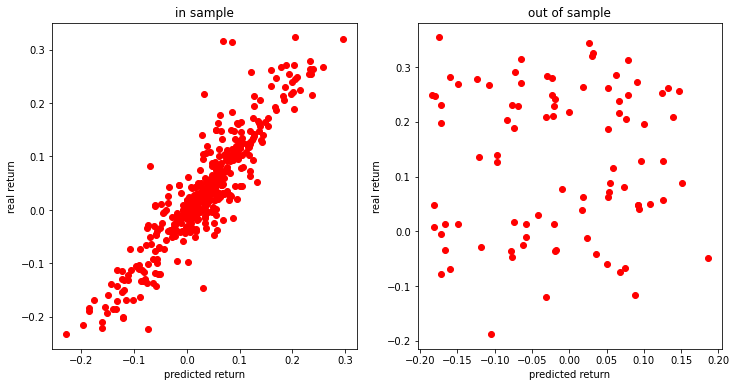

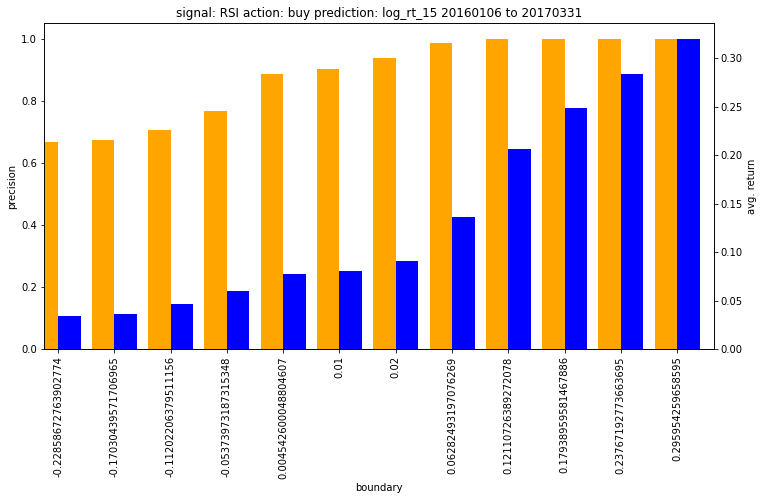

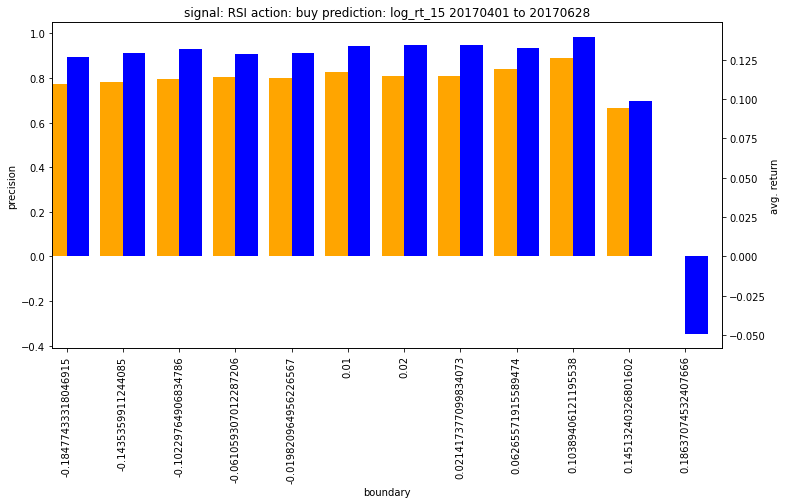

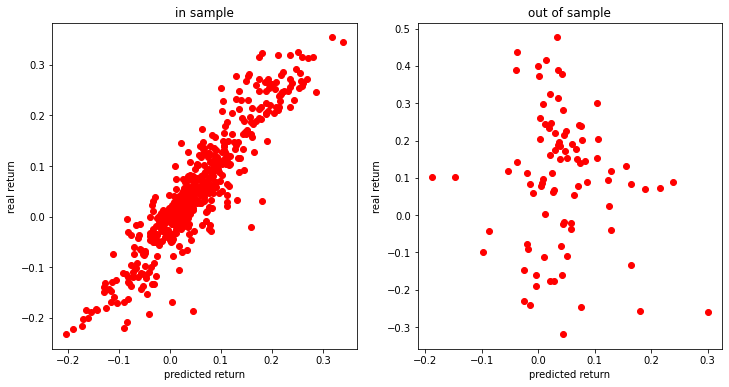

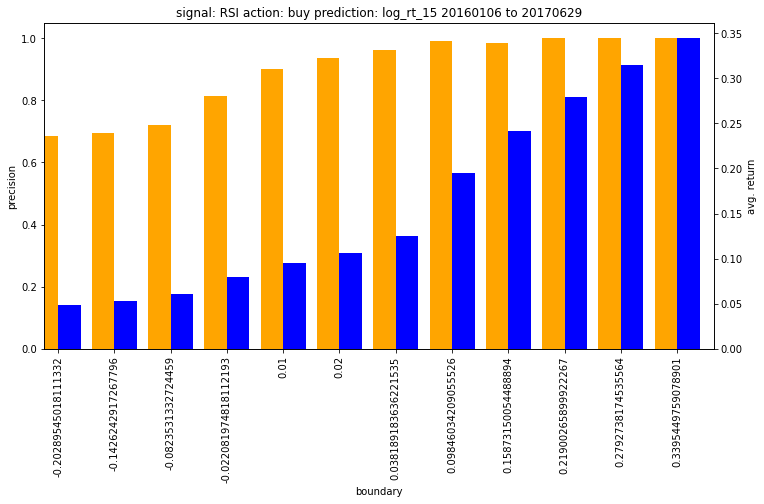

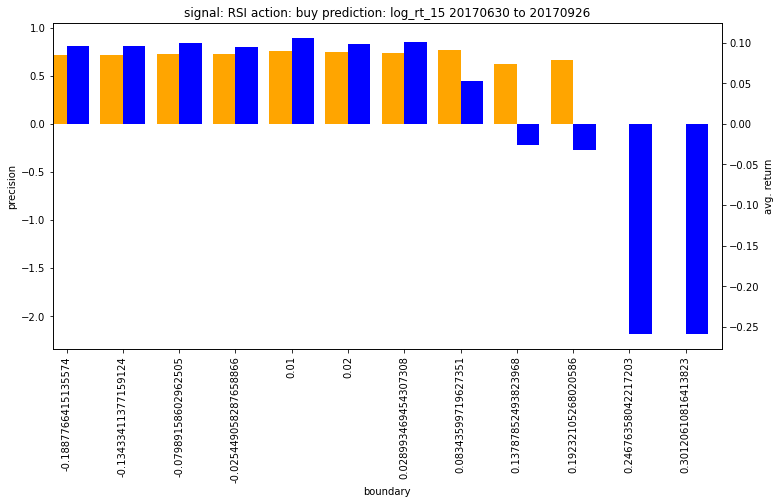

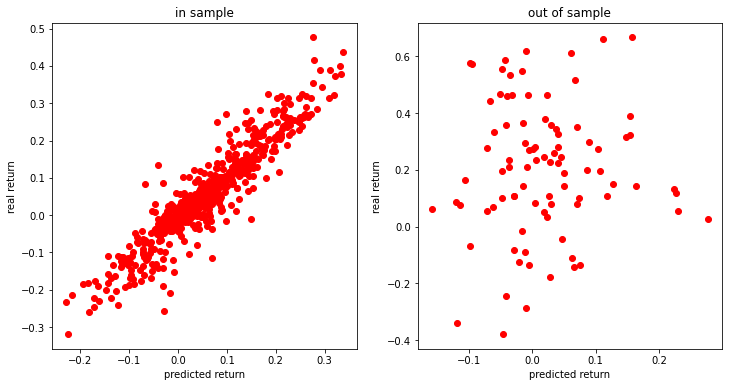

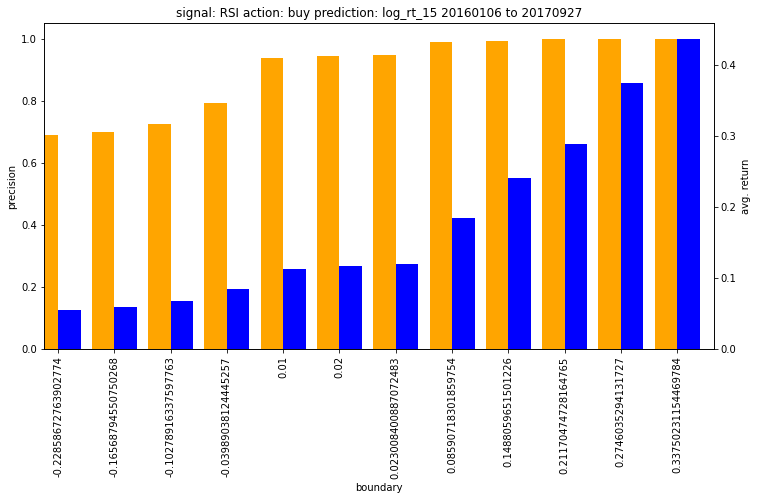

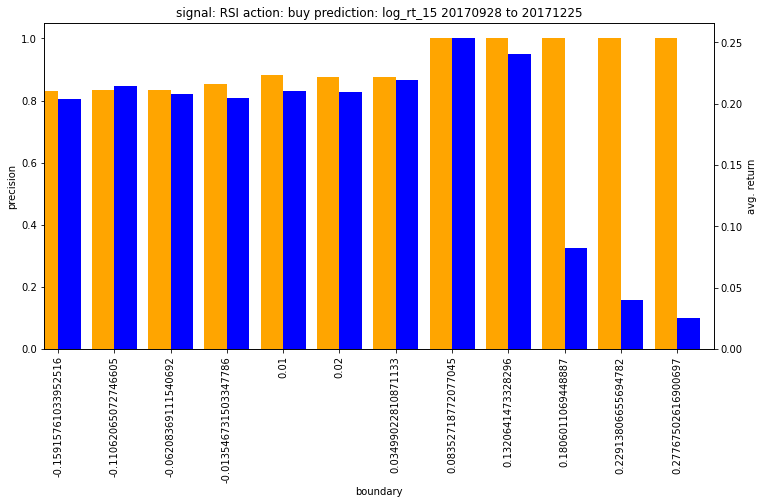

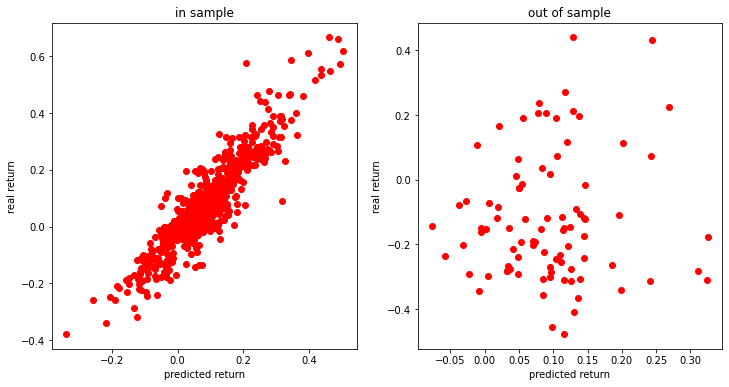

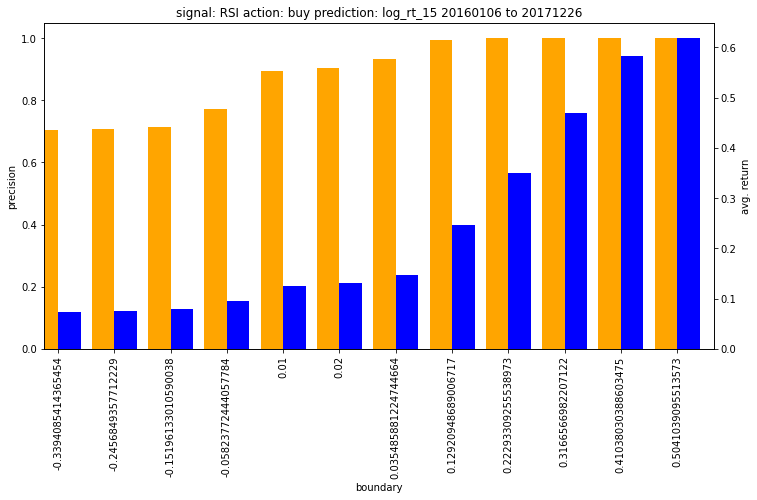

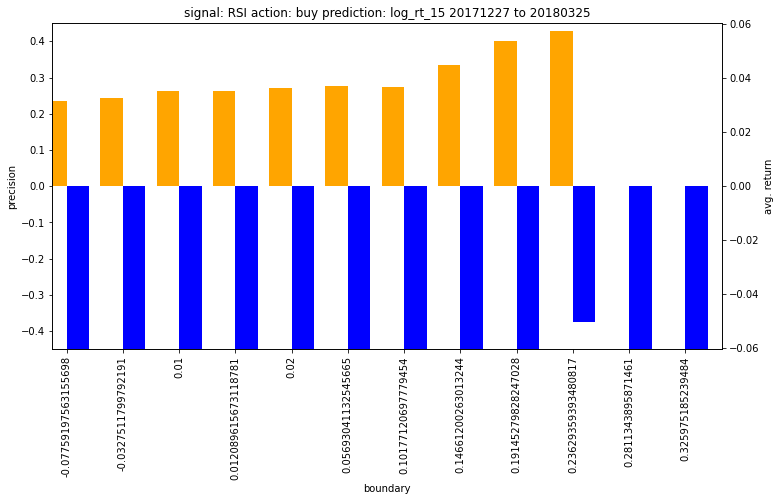

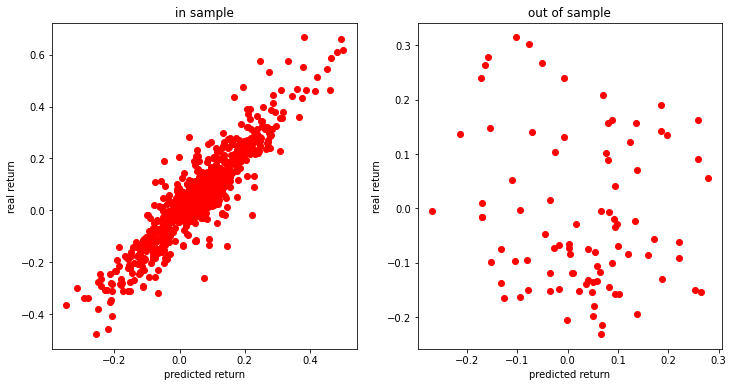

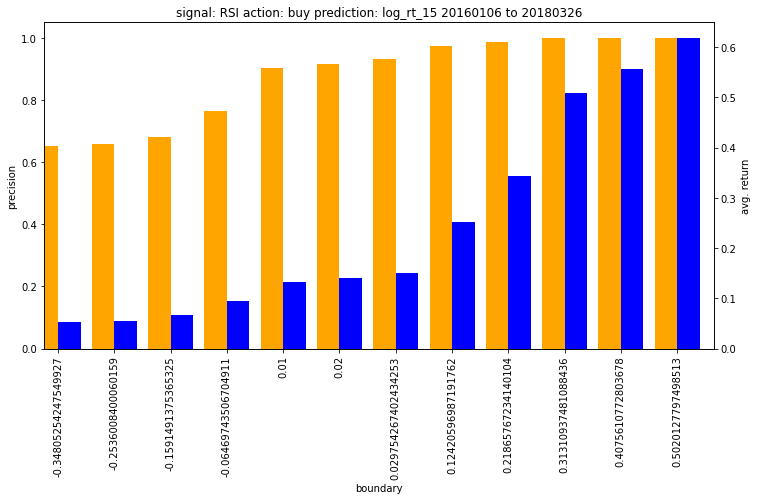

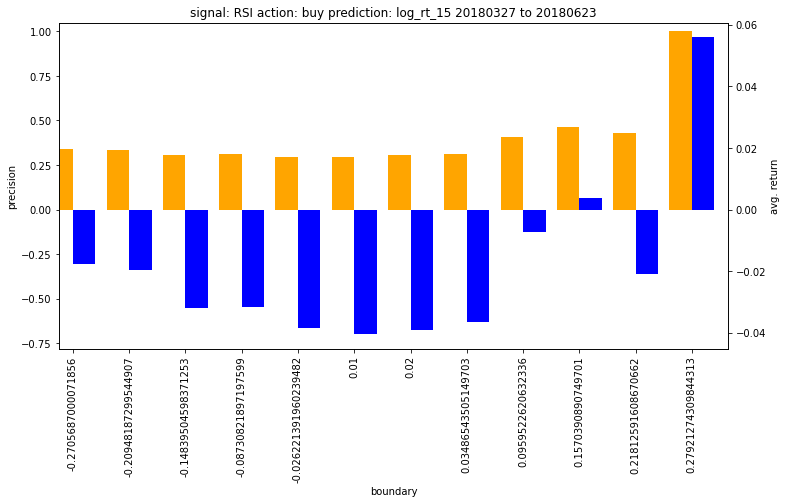

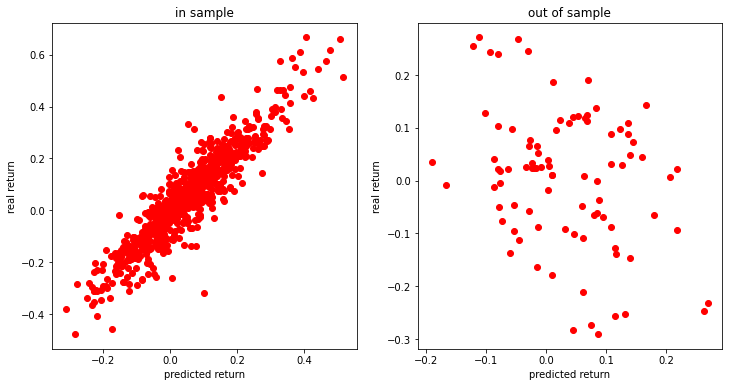

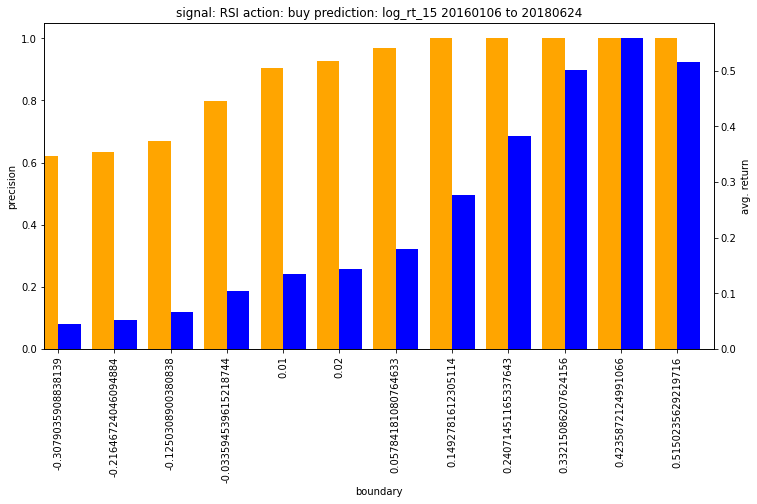

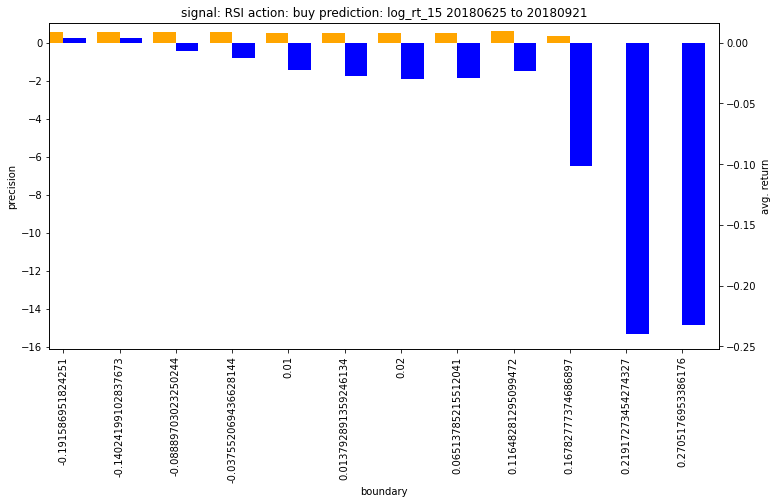

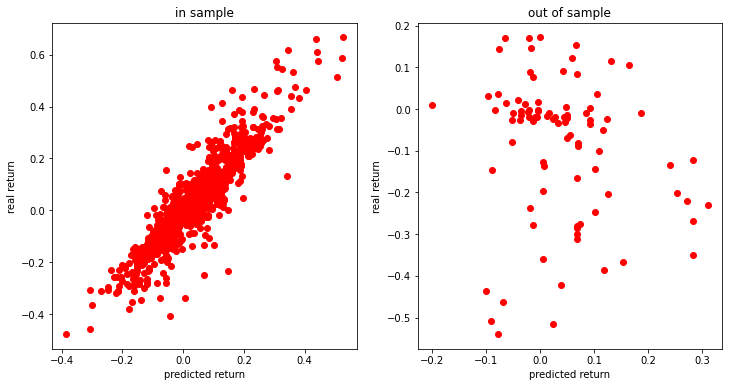

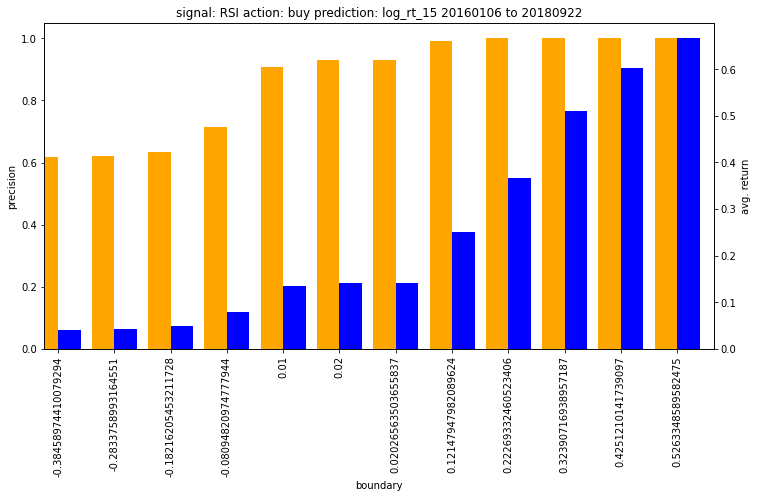

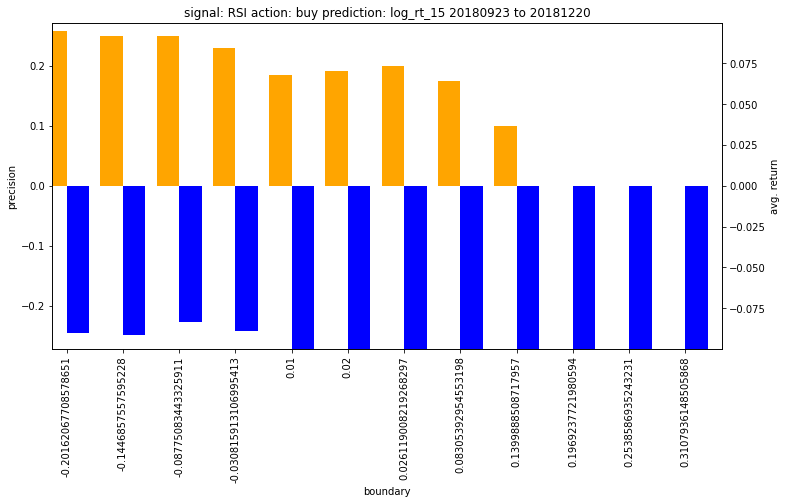

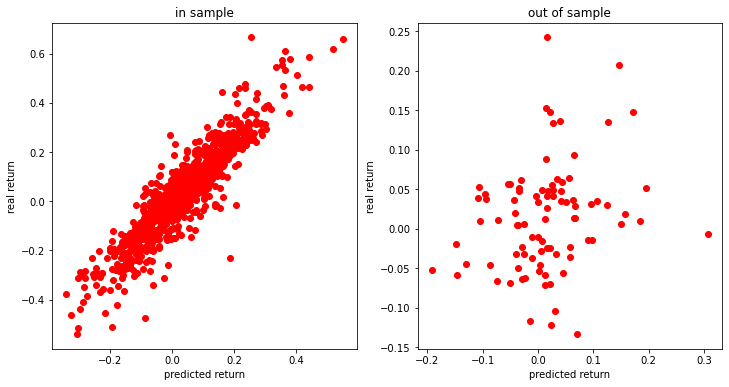

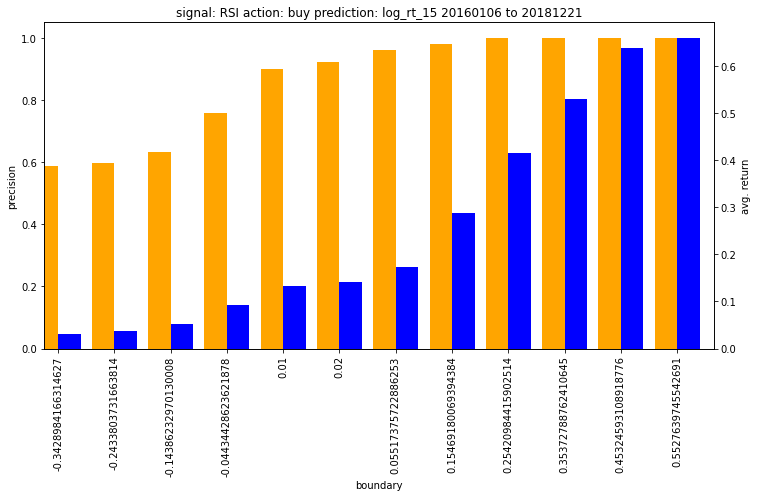

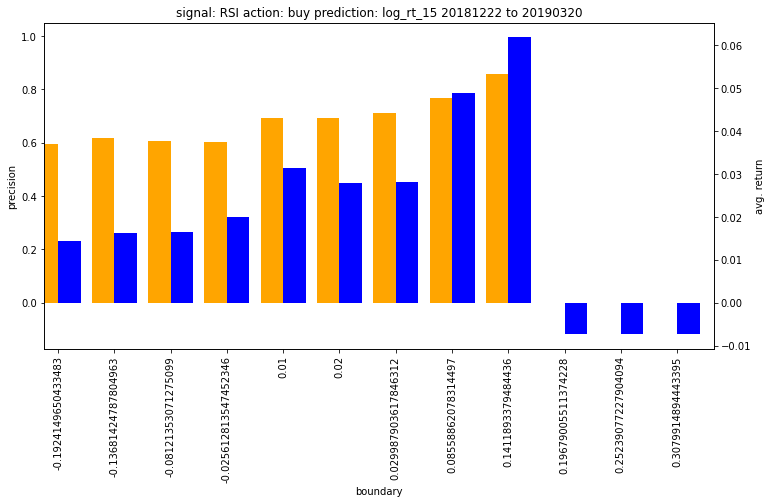

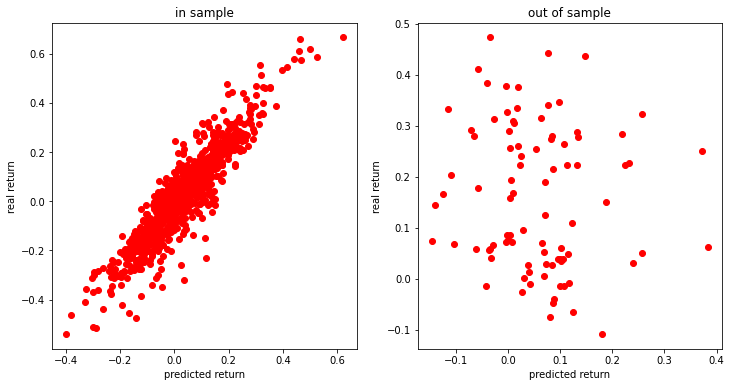

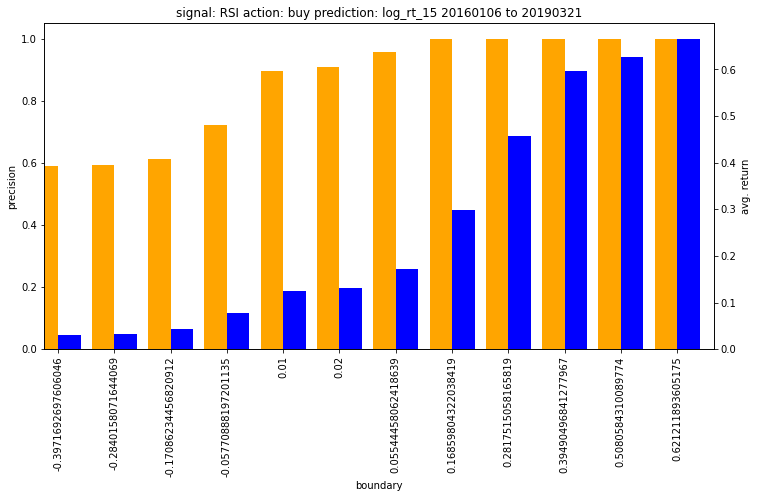

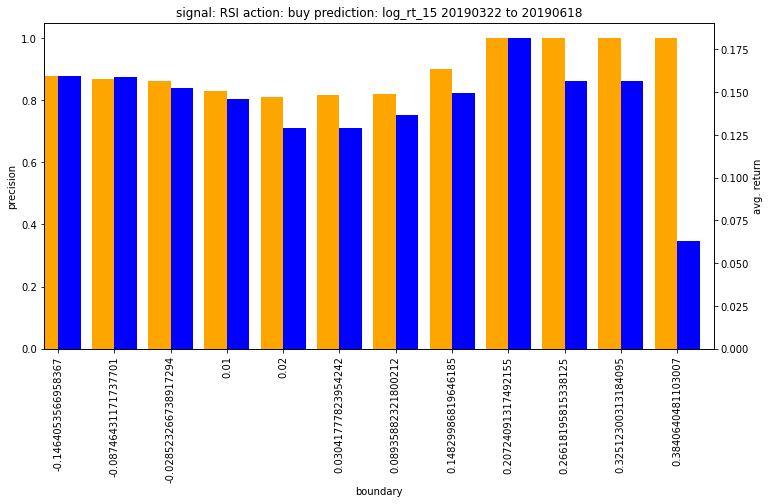

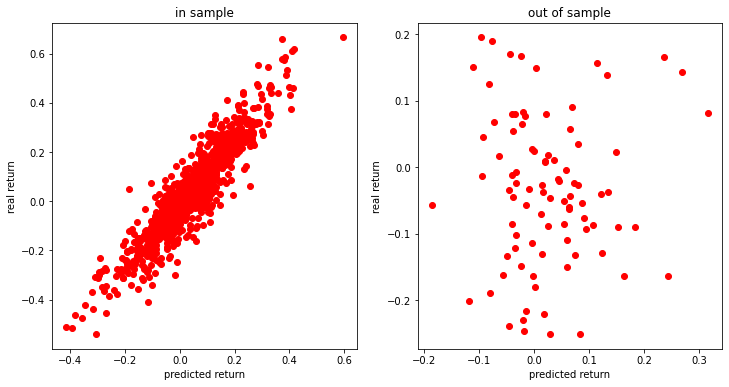

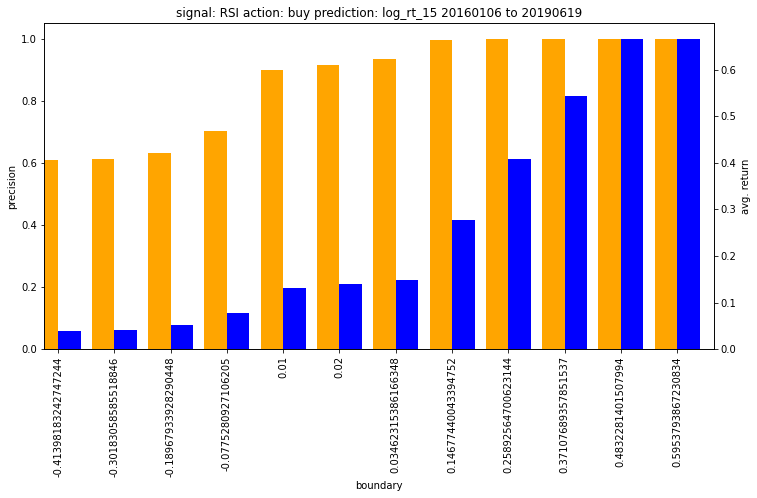

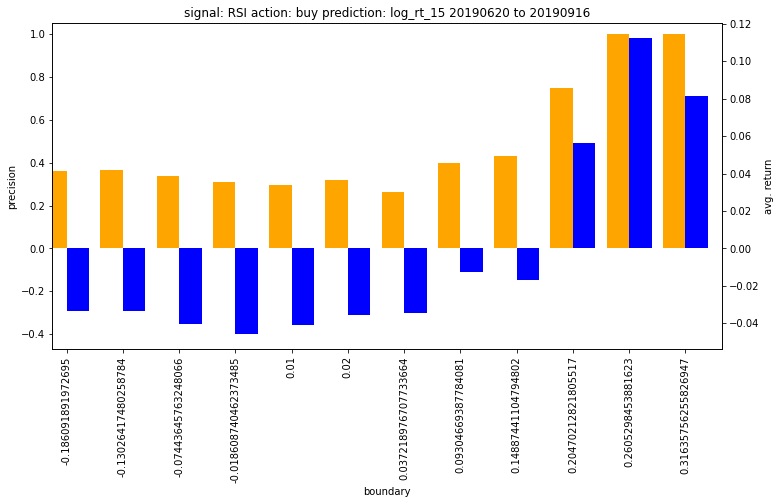

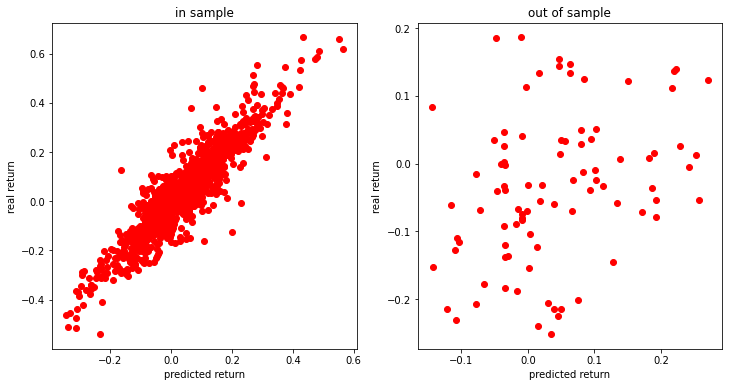

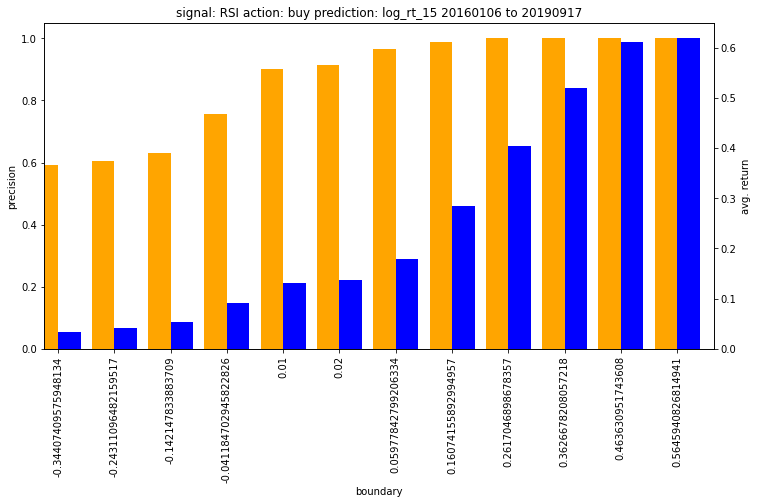

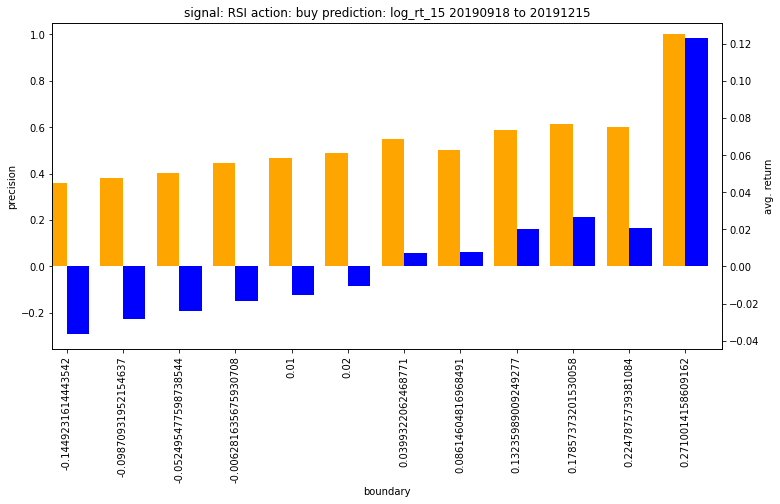

In [6]:
warnings.filterwarnings('ignore')
ml.fit_techs(X,Y,TID_name,target,5)